# Neopythen Distribution Model for Luxembourg -NDML
-----------------------------

by space4environment (2024)

- What this tool is doing?

The tool reads various spatial data for the city of Luxembourg which describe the habitat characteristics for plants.
The model will initially deal with a list of invasive species (IAS), but can also be used for other species.

The model includes the occurrence data of the invasive species. These are overlaid with spatial data which describes the habitat. This data is then used to map potential areas where the species could occur. 

The occurence data of the invasive species show only a small distribution, which is initially very good with regard to the spread of invasive species, but is somewhat difficult for the development of a distriubtion model. 
But we have a solution for an anhance version of the model:
Many plants need the same habitat parameter (ellenberg numbers). Therefore, we can group the invasive plants with all other plants into plant groups and then use these to extract the site properties from the spatial raster data.


In [1]:
# READ ELLENBERG LEGEND
import pandas as pd
ellenberg_csv = r'N:\C2205_FAIRiCUBE\f02_data\d060_data_LUXEMBOURG\f01_Lux_neopyhtes\f02_luxembourg_data\f02_raster_10m_collection\ellenberg\neophytes_ellenberg.csv'
df = pd.read_csv(ellenberg_csv,encoding="ISO-8859-1")
#print(df.to_string()) 



Constrution of datacube with 10m raster files which can be used to calculate the Ellenbergnumbers:




## (1) Reading dims

The following code is needed to load the different libaries

In [2]:
# Reading libaries:

import os
from pathlib import Path, WindowsPath
from glob import glob
from pathlib import Path
import geopandas as gpd

from pathlib import Path
import geopandas as gpd
import sys
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors



import rasterio
import rasterio.mask
import numpy as np
import subprocess
import pandas as pd
import xarray as xr
import rioxarray as rxr


print("job done")

job done


## (2) Building cube

### (2.1) Reading habitat parameter from raster files
The follwoing codes reads the different spatial datasets which should help to describe habitats inside 10m x 10m cells.

The single raster datasets where imported to Xarray CUBES
- https://docs.xarray.dev/en/stable/index.html

####### To do: collect also metadata from the used datasets !!
https://catalog.eoxhub.fairicube.eu/search

In [3]:
## reading raster from CWS:

##  base folder on CWS:
base_path = WindowsPath('N:/C2205_FAIRiCUBE/f02_data/d060_data_LUXEMBOURG/f01_Lux_neopyhtes/f02_luxembourg_data/f02_raster_10m_collection/ellenberg')


## Using Elleberg number to classify input datasets:
# 1	Lichtzahl (L-Zahl)
# 2	Feuchtezahl (F-Zahl)
# 3	Temperaturzahl (T-Zahl)
# 4	Kontinentalitätszahl (K-Zahl)
# 5	Reaktionszahl (R-Zahl)
# 6	Stickstoffzahl (N-Zahl)
# 7	Salzzahl (S-Zahl)
# 8	Schwermetallresistenz
# 9	Lebensform
# 10 Blattausdauer

## AOI
#--------------------------
#min_x = 3316000 
#max_x = 3345000

#max_y = 1780000
#min_y = 1799000 
#--------------------------

## Datasets 01 Lichtzahl:-------------------------------------------
d01_L_parameter = os.path.join(base_path, 'shadow_2019_10m_b1.tif')
print(d01_L_parameter)
# Open the file:
cube_01_L = rxr.open_rasterio(d01_L_parameter)
cube_01_L = cube_01_L.to_dataset(name='d01_L_light')

### Dataset 02 Feuchtezahl :-------------------------------------------
d02_F_parameter = os.path.join(base_path, 'twi_2019_10m_b1.tif')
print(d02_F_parameter)
# Open the file:
cube_02_F = rxr.open_rasterio(d02_F_parameter)
cube_02_F = cube_02_F.to_dataset(name='d02_F_wetness')

### Dataset 03 Temperatur:-----------------------------------------------------------------------------------------------------------S

### monthly temp for 2017
# Open the file:


d03_T_parameter_2017 = os.path.join(base_path, 'air_temperature_2017_month_mean_10m_b12.tif')
cube_03_T = rxr.open_rasterio(d03_T_parameter_2017)
cube_03_T = cube_03_T.to_dataset(name='d03_T_temperatur')
cube_03_T
#print(d03_T_parameter_2017)
## Open the file:
cube_03_T_stacked = xr.concat([cube_03_T.sel(band=i) for i in range(1, 13)], dim='month')
##print(cube_03_T_stacked)
###Celsius = Kelvin - 273.15
## Calculate the maximum across all bands
max_across_month = cube_03_T_stacked.max(dim='month')- 273.15
max_across_month = max_across_month.rename({'d03_T_temperatur': 'd03_T_max_temperatur_2017_celsius'})
## Calculate the min across all bands
min_across_month = cube_03_T_stacked.min(dim='month')- 273.15
min_across_month = min_across_month.rename({'d03_T_temperatur': 'd03_T_min_temperatur_2017_celsius'})
## Calculate the avg across all bands
avg_across_month = cube_03_T_stacked.mean(dim='month')- 273.15
avg_across_month = avg_across_month.rename({'d03_T_temperatur': 'd03_T_avg_temperatur_2017_celsius'})
### Merge three temperature min-max-avg datasets:
cube_03_temperature_2017 = xr.merge([max_across_month, min_across_month, avg_across_month])
#cube_03_temperature_2017

### Dataset 03 Temperatur:-----------------------------------------------------------------------------------------------------------E




### Dataset 04 Kontinentaliätzahl:-------------------------------------------
d04_K_parameter = os.path.join(base_path, 'air_temperature_2017_month_mean_10m_b12.tif')
print(d04_K_parameter)
# Open the file:
cube_04_K = rxr.open_rasterio(d04_K_parameter)
cube_04_K = cube_04_K.to_dataset(name='d04_K_continentality')

### Dataset 05 Reaktionszahl (ph):-------------------------------------------
d05_R_parameter = os.path.join(base_path, 'pH_CaCl_10m_b1.tif')
print(d05_R_parameter)
# Open the file:
cube_05_R = rxr.open_rasterio(d05_R_parameter)
cube_05_R = cube_05_R.to_dataset(name='d05_R_ph')

## ### Dataset 06 Stickstoff:-------------------------------------------
d06_N_parameter = os.path.join(base_path, 'soil_nitrat_10m_b1.tif')
print(d06_N_parameter)
## # Open the file:
cube_06_N = rxr.open_rasterio(d06_N_parameter)
cube_06_N = cube_06_N.to_dataset(name='d06_N_nitrogen')## 

## ### Dataset 07 Salz:------------------------------------------- NO DATA ()
## d07_S_parameter = os.path.join(base_path, 'xxx.tif')
## print(d07_S_parameter)
## # Open the file:
## cube_07_S = rxr.open_rasterio(d07_S_parameter)
## cube_07_S = cube_07_S.to_dataset(name='d07_S_salt')## 

## ### Dataset 08 Schwermetall:-------------------------------------------  NO DATA ()
## d08_HM_parameter = os.path.join(base_path, 'xxx.tif')
## print(d08_HM_parameter)
## # Open the file:
## cube_08_HM = rxr.open_rasterio(d08_HM_parameter)
## cube_08_HM = cube_08_HM.to_dataset(name='d08_HM_heavy_metal')

### Dataset 09 Lebensform:-------------------------------------------
d09_watersurface_raster = os.path.join(base_path, 'land_cover_2021_10m_b1.tif')
cube_09__temp_LF = rxr.open_rasterio(d09_watersurface_raster)
#print(cube_09__temp_LF)
cube_09__temp_LF = cube_09__temp_LF.to_dataset(name='d09_LV_landcover')

# -- landcover_code	landcover_name
# -- 10	buildings
# -- 20	other constructed areas
# -- 30	bare soil
# -- 60	water
# -- 70	trees
# -- 71	dead trees
# -- 80	bushes
# -- 91	permanent herbaceous vegetation
# -- 92	seasonal herbaceous vegetation
# -- 93	vineyards


ds = cube_09__temp_LF
d09_LF_parameter_temp_water_area =    xr.where(ds['d09_LV_landcover'] == 60, 1, 0) # Else set to 0
# Adding the result back to the dataset (optional)
cube_09__temp_LF['ellenberg_water_area'] = d09_LF_parameter_temp_water_area

cube_09_LF_x = cube_09__temp_LF['ellenberg_water_area'] 
cube_09_1_LF_water = cube_09_LF_x.to_dataset(name='ellenberg_water_area')
#cube_09_LF_water

d09_LF_parameter_temp_not_sealed =    xr.where(ds['d09_LV_landcover'].isin ([30,70,71,80,91,92,93]), 1, 0) # Else set to 0
# Adding the result back to the dataset (optional)
cube_09__temp_LF['ellenberg_not_sealed_area'] = d09_LF_parameter_temp_not_sealed
cube_09_LF_x_non_sealed = cube_09__temp_LF['ellenberg_not_sealed_area'] 
cube_09_2_LF_non_sealed = cube_09_LF_x_non_sealed.to_dataset(name='ellenberg_not_sealed_area')
#cube_09_LF_non_sealed



print ("job done-------------------------------")



N:\C2205_FAIRiCUBE\f02_data\d060_data_LUXEMBOURG\f01_Lux_neopyhtes\f02_luxembourg_data\f02_raster_10m_collection\ellenberg\shadow_2019_10m_b1.tif
N:\C2205_FAIRiCUBE\f02_data\d060_data_LUXEMBOURG\f01_Lux_neopyhtes\f02_luxembourg_data\f02_raster_10m_collection\ellenberg\twi_2019_10m_b1.tif
N:\C2205_FAIRiCUBE\f02_data\d060_data_LUXEMBOURG\f01_Lux_neopyhtes\f02_luxembourg_data\f02_raster_10m_collection\ellenberg\air_temperature_2017_month_mean_10m_b12.tif
N:\C2205_FAIRiCUBE\f02_data\d060_data_LUXEMBOURG\f01_Lux_neopyhtes\f02_luxembourg_data\f02_raster_10m_collection\ellenberg\pH_CaCl_10m_b1.tif
N:\C2205_FAIRiCUBE\f02_data\d060_data_LUXEMBOURG\f01_Lux_neopyhtes\f02_luxembourg_data\f02_raster_10m_collection\ellenberg\soil_nitrat_10m_b1.tif
job done-------------------------------


### (2.2)  Creation of a data-habitat cube 

In [191]:
# the following code set up ONE datacube with the raw data - (only to be used for model -tuning in the moment)


c_1 = cube_01_L 
c_2 = cube_02_F 
c_3 = cube_03_temperature_2017 
c_4 = cube_04_K 
c_5 = cube_05_R
c_6 = cube_06_N 
c_7 = cube_09__temp_LF 
c_8 = cube_09_1_LF_water 
c_9 = cube_09_2_LF_non_sealed 

habitat_parameter_cube = xr.merge([c_1, c_2, c_3,c_4, c_5, c_6,c_7, c_8, c_9])
#habitat_parameter_cube=habitat_parameter_cube.squeeze()
#habitat_parameter_cube


# the following code set up ONE datacube with the raw data - (only to be used for model -tuning in the moment)



## for masking of the final data we need an extra cube:
c_8 = cube_09_1_LF_water 
c_9 = cube_09_2_LF_non_sealed 

sealed_water_cube = xr.merge([ c_8, c_9])
#habitat_parameter_cube=habitat_parameter_cube.squeeze()
#habitat_parameter_cube



### (2.3) Reading Occurence data

The following box reads the occurence raster for 'heracleum mantegazzianum' in 10m resolution and in LUREF projection
- -> to do: direct connect to GBIF code and produce 

This occurence data should help to translate the raw data from the different raster files into Ellenberg numbers.


In [19]:

##  base folder on CWS:
base_path_distribution = WindowsPath(r'n:\C2205_FAIRiCUBE\f02_data\d060_data_LUXEMBOURG\f01_Lux_neopyhtes\f01_neophyte_species_data\raster')

## Datasets 01 Lichtzahl:-------------------------------------------
heracleum_mantegazzianum_parameter = os.path.join(base_path_distribution, 'heracleum_mantegazzianum_10m_2169.tif')
print(heracleum_mantegazzianum_parameter)
# Open the file:
Occurrence_cube = rxr.open_rasterio(heracleum_mantegazzianum_parameter)
Occurrence_cube = Occurrence_cube.to_dataset(name='heracleum_mantegazzianum_occurence')


Occurrence_cube=Occurrence_cube.squeeze()


n:\C2205_FAIRiCUBE\f02_data\d060_data_LUXEMBOURG\f01_Lux_neopyhtes\f01_neophyte_species_data\raster\heracleum_mantegazzianum_10m_2169.tif


### (2.4) Combine of Occurence data with habitat cube
Next we can overlay the occurence data witht the habitat data:

In [20]:
# the following code build a cube of habitat parameter and occurence data:

habitat_parameter_cube_wit_occurence = xr.merge([Occurrence_cube, habitat_parameter_cube])
#habitat_parameter_cube_wit_occurence=habitat_parameter_cube_wit_occurence.squeeze()

habitat_parameter_cube_wit_occurence

<xarray.Dataset>
Dimensions:                             (x: 980, y: 1048, band: 12)
Coordinates:
  * x                                   (x) float64 7.278e+04 ... 8.256e+04
  * y                                   (y) float64 6.96e+04 ... 8.006e+04
  * band                                (band) int32 1 2 3 4 5 6 7 8 9 10 11 12
    spatial_ref                         int32 0
Data variables:
    heracleum_mantegazzianum_occurence  (y, x) float64 nan nan nan ... nan nan
    d01_L_light                         (band, y, x) float32 nan nan ... nan nan
    d02_F_wetness                       (band, y, x) float32 nan nan ... nan nan
    d03_T_max_temperatur_2017_celsius   (y, x) float32 nan nan nan ... nan nan
    d03_T_min_temperatur_2017_celsius   (y, x) float32 nan nan nan ... nan nan
    d03_T_avg_temperatur_2017_celsius   (y, x) float32 nan nan nan ... nan nan
    d04_K_continentality                (band, y, x) float32 nan nan ... nan nan
    d05_R_ph                            (band, y, x) float32 nan nan ... nan nan
    d06_N_nitrogen                      (band, y, x) float32 nan nan ... nan nan
    d09_LV_landcover                    (band, y, x) float64 nan nan ... nan nan
    ellenberg_water_area                (band, y, x) float64 nan nan ... nan nan
    ellenberg_not_sealed_area           (band, y, x) float64 nan nan ... nan nan

To calculate the statistics (such as min, avg, max, count) for the areas where heracleum_mantegazzianum_occurence is not NaN, we  mask these data variables based on the condition that heracleum_mantegazzianum_occurence is not NaN. T

In [21]:
# List all data variables in the xarray Dataset
#print(habitat_parameter_cube_wit_occurence.data_vars)
# Get the names of the data variables
variable_names = list(habitat_parameter_cube_wit_occurence.data_vars)
for name in variable_names:
    
    print(name)


heracleum_mantegazzianum_occurence
d01_L_light
d02_F_wetness
d03_T_max_temperatur_2017_celsius
d03_T_min_temperatur_2017_celsius
d03_T_avg_temperatur_2017_celsius
d04_K_continentality
d05_R_ph
d06_N_nitrogen
d09_LV_landcover
ellenberg_water_area
ellenberg_not_sealed_area


Map data from Cube:

In [80]:
habitat_parameter_cube_wit_occurence

<xarray.Dataset>
Dimensions:                             (x: 980, y: 1048, band: 12)
Coordinates:
  * x                                   (x) float64 7.278e+04 ... 8.256e+04
  * y                                   (y) float64 6.96e+04 ... 8.006e+04
  * band                                (band) int32 1 2 3 4 5 6 7 8 9 10 11 12
    spatial_ref                         int32 0
Data variables:
    heracleum_mantegazzianum_occurence  (y, x) float64 nan nan nan ... nan nan
    d01_L_light                         (band, y, x) float32 nan nan ... nan nan
    d02_F_wetness                       (band, y, x) float32 nan nan ... nan nan
    d03_T_max_temperatur_2017_celsius   (y, x) float32 nan nan nan ... nan nan
    d03_T_min_temperatur_2017_celsius   (y, x) float32 nan nan nan ... nan nan
    d03_T_avg_temperatur_2017_celsius   (y, x) float32 nan nan nan ... nan nan
    d04_K_continentality                (band, y, x) float32 nan nan ... nan nan
    d05_R_ph                            (band, y, x) float32 nan nan ... nan nan
    d06_N_nitrogen                      (band, y, x) float32 nan nan ... nan nan
    d09_LV_landcover                    (band, y, x) float64 nan nan ... nan nan
    ellenberg_water_area                (band, y, x) float64 nan nan ... nan nan
    ellenberg_not_sealed_area           (band, y, x) float64 nan nan ... nan nan

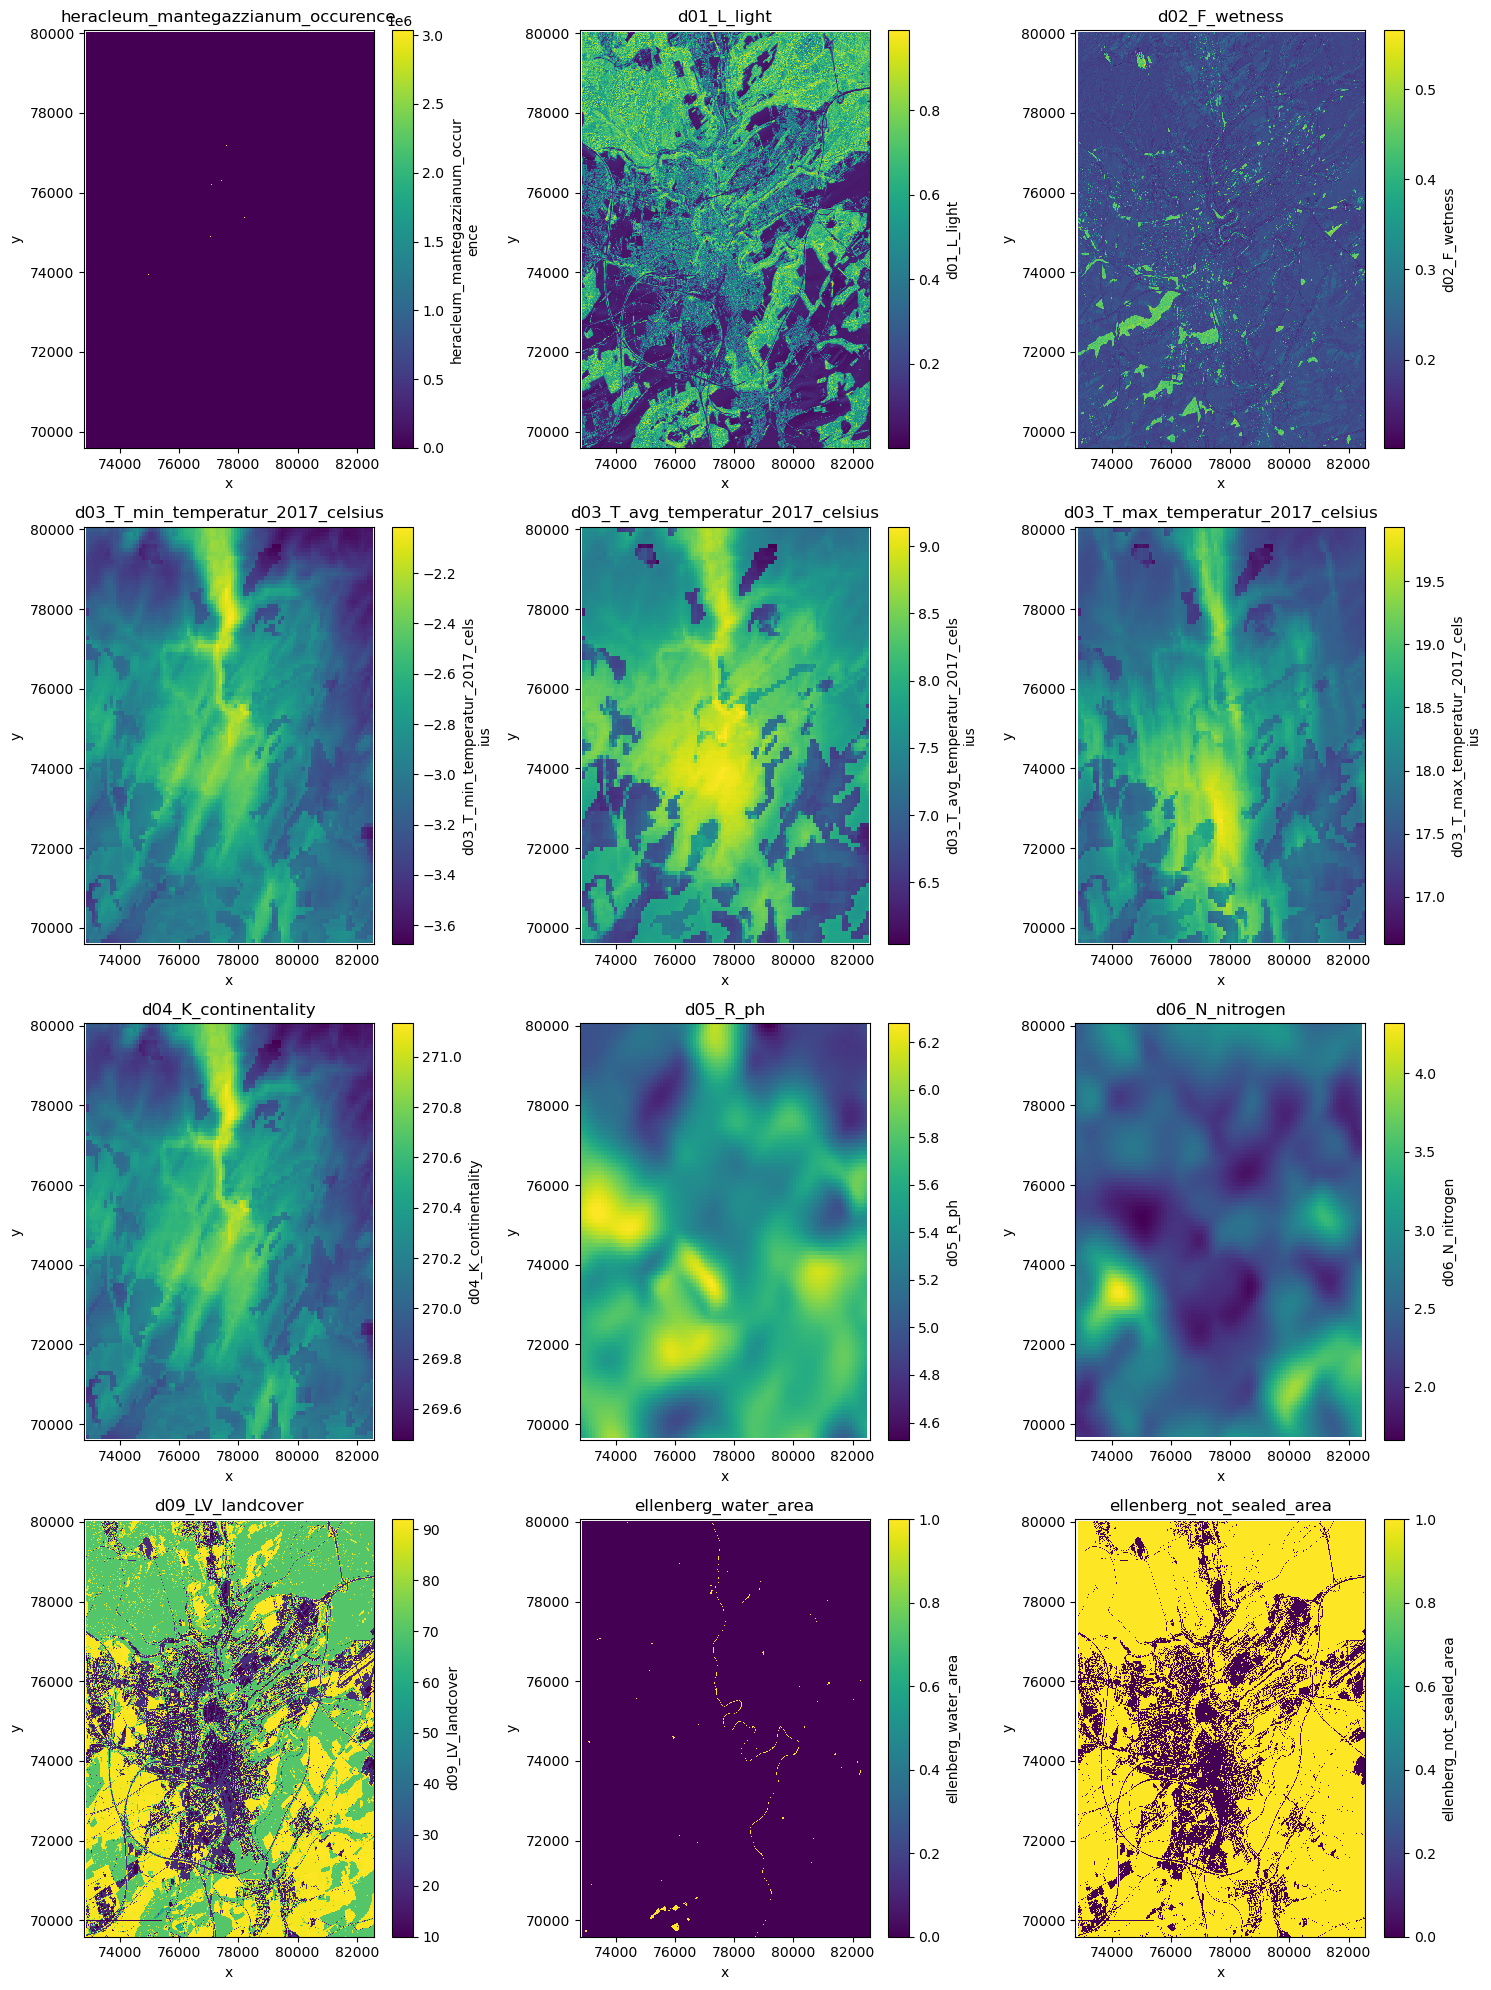

In [81]:

# Showing cube data


# Create the list of variables and names
parameters = [
    habitat_parameter_cube_wit_occurence.heracleum_mantegazzianum_occurence,
    habitat_parameter_cube_wit_occurence.d01_L_light.sel(band=1),
    habitat_parameter_cube_wit_occurence.d02_F_wetness.sel(band=1),
    habitat_parameter_cube_wit_occurence.d03_T_min_temperatur_2017_celsius,
    habitat_parameter_cube_wit_occurence.d03_T_avg_temperatur_2017_celsius,
    habitat_parameter_cube_wit_occurence.d03_T_max_temperatur_2017_celsius,
    habitat_parameter_cube_wit_occurence.d04_K_continentality.sel(band=1),
    habitat_parameter_cube_wit_occurence.d05_R_ph.sel(band=1),
    habitat_parameter_cube_wit_occurence.d06_N_nitrogen.sel(band=1),
    habitat_parameter_cube_wit_occurence.d09_LV_landcover.sel(band=1),
    habitat_parameter_cube_wit_occurence.ellenberg_water_area.sel(band=1),
    habitat_parameter_cube_wit_occurence.ellenberg_not_sealed_area.sel(band=1)
]

parameter_names = [
    'heracleum_mantegazzianum_occurence', 'd01_L_light', 'd02_F_wetness',
    'd03_T_min_temperatur_2017_celsius', 'd03_T_avg_temperatur_2017_celsius',
    'd03_T_max_temperatur_2017_celsius', 'd04_K_continentality', 'd05_R_ph',
    'd06_N_nitrogen', 'd09_LV_landcover', 'ellenberg_water_area', 'ellenberg_not_sealed_area'
]

# Plot each variable
plt.figure(figsize=(15, 20))

for i, param in enumerate(parameters):
    plt.subplot(4, 3, i + 1)  # Create a grid of subplots
    param.plot()  # No need to specify 'cmap' here, it will default
    plt.title(parameter_names[i])

plt.tight_layout()
plt.show()



## (3)  Potential distribtuion maps


### (3.1)  Reading Training data from Heracleum Mantegazzianum distribution

To use the data variable heracleum_mantegazzianum_occurence as training data and extract values from the other variables for each pixel, you can follow these steps:

- Create a DataFrame from your xarray dataset: This will help you extract the values for each pixel across all variables easily.

- Prepare the training dataset: Extract the feature values (from other variables) along with the target variable (heracleum_mantegazzianum_occurence).

- Handle NaN values: It’s often useful to handle missing data (e.g., NaN values) before training your model.

- Train a classification model: Use a suitable machine learning model to classify the occurrences based on the extracted features.


https://github.com/FAIRiCUBE/uc5-occurence-cubes/blob/main/Notebooks/1_data-preprocess/1_poc_probability-map.ipynb

#### (3.1.1)   Trainingdata for occurence

In [123]:
# Convert xarray dataset to DataFrame

df = habitat_parameter_cube_wit_occurence.to_dataframe().reset_index()
#Now, create a new DataFrame containing only the relevant features and the target variable:
# Specify the feature variables
feature_columns = [
    'd01_L_light',
    'd02_F_wetness',
    'd03_T_max_temperatur_2017_celsius',
    'd03_T_min_temperatur_2017_celsius',
    'd03_T_avg_temperatur_2017_celsius',
    'd04_K_continentality',
    'd05_R_ph',
    'd06_N_nitrogen',
    'd09_LV_landcover',
    'ellenberg_water_area',
    'ellenberg_not_sealed_area'
]

# Create a new DataFrame with features and target variable
training_data = df[['heracleum_mantegazzianum_occurence'] + feature_columns]

# Drop rows where heracleum_mantegazzianum_occurence is 0
training_data = training_data[training_data['heracleum_mantegazzianum_occurence'] != 0]

training_data['training_type']= 'occurence'  # info: that this row is based on occurenct selection
training_data['ID'] = range(len(training_data))  # Add an ID column based on row number starting from 0

# Drop rows with NaN in the target variable or any feature columns
training_data.dropna(inplace=True)

# Separate features and target variable
x_occurence = training_data[feature_columns]  # Features
y_occurence = training_data['heracleum_mantegazzianum_occurence']  # Target

# Count the number of rows using len()
row_count_len = len(training_data)
print("Number of occurence sample", row_count_len)


Number of occurence sample 52


#### (3.1.2)   Trainingdata for NON occurence 

In [124]:
# Convert xarray dataset to DataFrame

df = habitat_parameter_cube_wit_occurence.to_dataframe().reset_index()
#Now, create a new DataFrame containing only the relevant features and the target variable:
# Specify the feature variables
feature_columns = [
    'd01_L_light',
    'd02_F_wetness',
    'd03_T_max_temperatur_2017_celsius',
    'd03_T_min_temperatur_2017_celsius',
    'd03_T_avg_temperatur_2017_celsius',
    'd04_K_continentality',
    'd05_R_ph',
    'd06_N_nitrogen',
    'd09_LV_landcover',
    'ellenberg_water_area',
    'ellenberg_not_sealed_area'
]

# Create a new DataFrame with features and target variable
training_data_outside = df[['heracleum_mantegazzianum_occurence'] + feature_columns]

# Drop rows where heracleum_mantegazzianum_occurence is 0
training_data_outside = training_data_outside[training_data_outside['heracleum_mantegazzianum_occurence'] == 0]

training_data_outside['training_type']= 'outside occurence'  # info: that this row is based on non occurenct selection


# Drop rows with NaN in the target variable or any feature columns
training_data_outside.dropna(inplace=True)


# Randomly select pixel (same number then occurenc cube)
random_sites = training_data_outside.sample(n=row_count_len, random_state=42)  # random_state for reproducibility
training_data_outside = random_sites

# Separate features and target variable
x_outside = training_data_outside[feature_columns]  # Features
y_outside = training_data_outside['heracleum_mantegazzianum_occurence']  # Target

# Count the number of rows using len()
row_count_len_outside = len(training_data_outside)
print("Number of occurence sample", row_count_len_outside)

### random select trainingsdata from outside occurence:





Number of occurence sample 52


#### (3.1.3)   Merge both trainingsdata 

In [130]:
# Concatenate pre sampled data

x = pd.concat([x_occurence,x_outside])

y = pd.concat([y_occurence,y_outside])


print(x)

         d01_L_light  d02_F_wetness  d03_T_max_temperatur_2017_celsius  \
1678116     0.596056       0.198540                          18.570221   
2457588     0.401498       0.208080                          18.723114   
2533008     0.728225       0.200708                          18.632965   
2558172     0.768809       0.477679                          18.632965   
2570736     0.702228       0.459080                          18.632965   
...              ...            ...                                ...   
2375424     0.579965       0.212581                          17.477905   
792468      0.452939       0.172448                          18.178497   
1147368     0.096621       0.212047                          17.620544   
5762424     0.263819       0.167305                          19.364777   
3156084     0.746534       0.172759                          17.453156   

         d03_T_min_temperatur_2017_celsius  d03_T_avg_temperatur_2017_celsius  \
1678116                       

### (3.2)  Train a Classification Model

In [127]:
#Feature Scaling: Normalize or standardize your feature variables to ensure they are on a similar scale, especially if using algorithms sensitive to the scale of data (like SVMs).

# from sklearn.preprocessing import StandardScaler
# 
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)
# x = X_scaled

In [133]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Initialize the model
model = RandomForestClassifier()

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred, zero_division=0))


              precision    recall  f1-score   support

         0.0       0.86      0.86      0.86        14
   3034824.0       0.89      0.89      0.89        18

    accuracy                           0.88        32
   macro avg       0.87      0.87      0.87        32
weighted avg       0.88      0.88      0.88        32



### (3.3)  Classification and storing

In [182]:
#Assuming you have your trained model (model), you can use it to predict on the entire feature dataset.
# Use the original DataFrame to predict on all data
all_features = df[feature_columns].dropna()  # Ensure we drop NaN values

# Make predictions
predictions = model.predict(all_features)

# Add predictions to the original DataFrame (after dropping NaNs)
df.loc[all_features.index, 'predicted_occurrence'] = predictions

# You need to reshape the predictions back to the original spatial format. If your xarray dataset has spatial dimensions (e.g., x and y), you can do this by using the coordinates of the original xarray dataset.
# Create a new DataFrame to store the predictions in spatial format
predicted_df = df[['x', 'y', 'predicted_occurrence']].dropna()

# Reshape the DataFrame to a 2D array for plotting
predicted_map = predicted_df.pivot(index='y', columns='x', values='predicted_occurrence')

#predicted_map = predicted_df.pivot(index='x', columns='y', values='predicted_occurrence')



# Display the predicted map shape
print(predicted_map.shape)


(1036, 962)


In [183]:
# Convert the pivoted DataFrame to an xarray DataArray
#data_array = xr.DataArray(predicted_map)

results_xarray = xr.DataArray(
    data=predicted_map.values,            # 2D array of predicted_occurrence
    dims=["y", "x"],                 # Dimension names
    coords={"x": predicted_map.columns,   # x coordinates (columns from the pivoted DataFrame)
            "y": predicted_map.index},    # y coordinates (index from the pivoted DataFrame)
    name="predicted_occurrence"      # Name of the variable
)

results_xarray


<xarray.DataArray 'predicted_occurrence' (y: 1036, x: 962)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * x        (x) float64 7.286e+04 7.286e+04 7.288e+04 ... 8.246e+04 8.246e+04
  * y        (y) float64 6.968e+04 6.968e+04 6.97e+04 ... 8.002e+04 8.002e+04

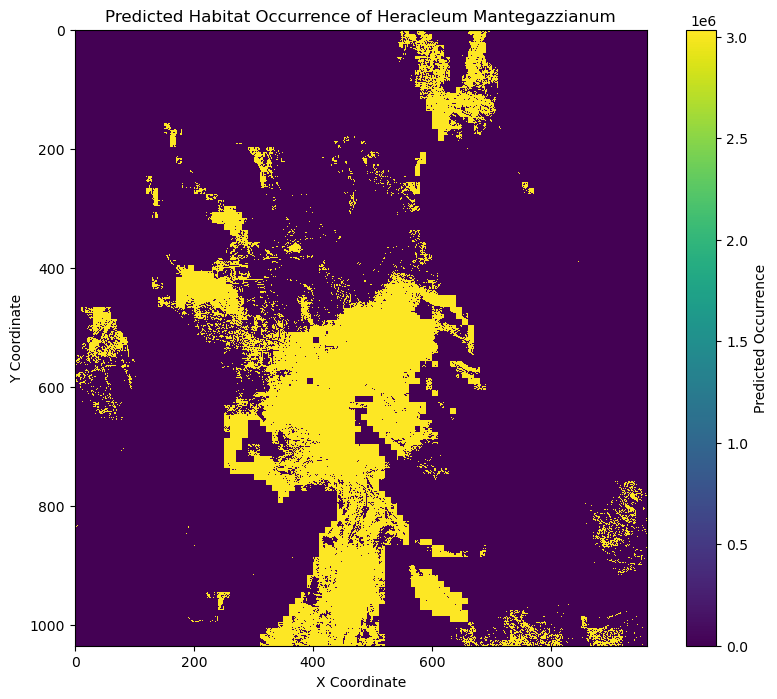

In [184]:
# plot maps

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(predicted_map, cmap='viridis', interpolation='nearest')  # Choose a colormap
plt.colorbar(label='Predicted Occurrence')
plt.title('Predicted Habitat Occurrence of Heracleum Mantegazzianum')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


### (3.4)  QC of map and model

In [137]:
## QC calculation:

# # Get the true and predicted values
# true_values =      qc_combined_array['heracleum_mantegazzianum_occurence'].values
# predicted_values = qc_combined_array['Heracleum_Mantegazzianum'].values
# 
# # Flatten the arrays (in case they are multidimensional)
# true_values_flat      = true_values.flatten()
# predicted_values_flat = predicted_values.flatten()
# 
# # Calculate True Positives, True Negatives, False Positives, and False Negatives
# TP = np.sum((true_values_flat == 1) & (predicted_values_flat == 1))  # True Positives
# TN = np.sum((true_values_flat == 0) & (predicted_values_flat == 0))  # True Negatives
# FP = np.sum((true_values_flat == 0) & (predicted_values_flat == 1))  # False Positives
# FN = np.sum((true_values_flat == 1) & (predicted_values_flat == 0))  # False Negatives
# 
# # Calculate accuracy
# accuracy = (TP + TN) / (TP + TN + FP + FN)*100
# 
# # Calculate precision, recall, and F1 score
# precision = TP / (TP + FP) if (TP + FP) > 0 else 0
# recall = TP / (TP + FN) if (TP + FN) > 0 else 0
# f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
# 
# # Print the results
# print(f"True Positives (TP): {TP}")
# print(f"True Negatives (TN): {TN}")
# print(f"False Positives (FP): {FP}")
# print(f"False Negatives (FN): {FN}")
# print(f"Accuracy: {accuracy:.2f}")
# print(f"Precision: {precision:.2f}")
# print(f"Recall: {recall:.2f}")
# print(f"F1 Score: {f1_score:.2f}")


In [139]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import confusion_matrix# 

# # Calculate the confusion matrix
# conf_matrix = confusion_matrix(true_values_flat, predicted_values_flat)# 

# # Plot the confusion matrix
# plt.figure(figsize=(6, 6))
# sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted Negative', 'Predicted Positive'], 
#             yticklabels=['True Negative', 'True Positive'])
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()


### (3.3)  Export to raster

In [167]:
results_xarray

<xarray.DataArray 'predicted_occurrence' (y: 1036, x: 962)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * x        (x) float64 7.286e+04 7.286e+04 7.288e+04 ... 8.246e+04 8.246e+04
  * y        (y) float64 6.968e+04 6.968e+04 6.97e+04 ... 8.002e+04 8.002e+04

### (3.3.1)  Mask out ares (sealed areas)

In [193]:
## for masking sealed areas
c_10 = results_xarray 
c_11 = sealed_water_cube 

test_cube = xr.merge([ c_10, c_11])

In [194]:
test_cube

<xarray.Dataset>
Dimensions:                    (x: 972, y: 1044, band: 1)
Coordinates:
  * x                          (x) float64 7.286e+04 7.286e+04 ... 8.256e+04
  * y                          (y) float64 6.96e+04 6.96e+04 ... 8.002e+04
  * band                       (band) int32 1
    spatial_ref                int32 0
Data variables:
    predicted_occurrence       (y, x) float64 nan nan nan nan ... nan nan nan
    ellenberg_water_area       (band, y, x) int32 0 0 0 0 0 0 0 ... 0 0 0 0 0 0
    ellenberg_not_sealed_area  (band, y, x) int32 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

### (3.3.2)  Mask out ares (water areas) - if non water species

In [190]:
import rasterio
from pyproj import CRS
from rasterio.transform import from_origin

##  base folder on CWS:
output_dir = WindowsPath(r'N:\C2205_FAIRiCUBE\f02_data\d060_data_LUXEMBOURG\f01_Lux_neopyhtes\f02_luxembourg_data\f05_distribution\f02_distribution_model_luxembourg')

species_name = 'Heracleum_Mantegazzianum'
output_file = f"{output_dir}/{species_name}.tif"

# Assuming 'data_array' is the DataArray containing the data and coordinates
data_array = results_xarray

# Extract the x and y coordinates (assuming they are uniformly spaced)
x_coords = data_array.coords['x'].values
y_coords = data_array.coords['y'].values

# Get the resolution (assuming evenly spaced coordinates)
#x_res = (x_coords[-1] - x_coords[0]) / (len(x_coords) - 1)
#y_res = (y_coords[-1] - y_coords[0]) / (len(y_coords) - 1)

x_res =10
y_res =10

# Define the affine transformation (top-left corner and pixel size)
#transform = from_origin(x_coords[0], y_coords[0], x_res, y_res)

# Create the affine transformation starting from the bottom-left corner
transform = from_origin(x_coords[0], y_coords[1], x_res, -y_res)

# Define output GeoTIFF file path
output_raster = output_file
# Write the DataArray to a GeoTIFF file
with rasterio.open(
    output_raster,
    'w',
    driver='GTiff',
    height=data_array.shape[0],  # Number of rows
    width=data_array.shape[1],   # Number of columns
    count=1,                     # Number of bands (1 for single-band raster)
    dtype=data_array.dtype,      # Data type (e.g., float32)
    crs = CRS.from_epsg(2169),
    #crs='EPSG:2169',             # Coordinate system, replace with appropriate EPSG (e.g., UTM)  data_var = data_var.rio.set_crs("EPSG:2169")
    transform=transform          # Affine transformation (pixel to map coordinates)
) as dst:
    dst.write(data_array.values, 1)  # Write the data to the first band

print ("done")


# Define the output text file path
output_file = f"{output_dir}/{species_name}_parameter.csv"

# Write the parameters to a text file
with open(output_file, "w") as file:
    file.write('For the Lux Distribution model 1, following model parameter were used:\n')
    file.write('----------------:\n')
    file.write(f"input datasets: {feature_columns}\n")
    file.write('----------------:\n')
    file.write(f"species: {species_name}\n")
    file.write('---------------:\n')
    file.write('github:\n')
    file.write('https://github.com/FAIRiCUBE/uc1-urban-climate/blob/e5b15891033a2dbadfb77aeffe58b3a0fbe0424c/notebooks/dev/f07_neopythen/neopythen_distribution_model_luxembourg_NDML.ipynb\n')


print ("Export done")



done
Export done


In [169]:
from pyproj import CRS

# Attempt to parse the WKT string
try:
    crs = CRS.from_wkt(wkt_string)
    print(crs)
except Exception as e:
    print(f"Error parsing WKT: {e}")

Error parsing WKT: name 'wkt_string' is not defined


In [ ]:
## first export dataframe into a xarray



In [201]:
# export resutls to raster

# Define the output file path

##  base folder on CWS:
output_dir = WindowsPath(r'N:\C2205_FAIRiCUBE\f02_data\d060_data_LUXEMBOURG\f01_Lux_neopyhtes\f02_luxembourg_data\f05_distribution\f01_distribution_ellenberg_model_1')


# # Loop through all data variables in the xarray Dataset
# for var_name in pot_distribution_ds.data_vars:
#     print (var_name)
#     # Access the data variable
#     data_var = pot_distribution_ds[var_name]
#     
#     # Make sure the data variable has CRS and transformation information (set if needed)
#     if not data_var.rio.crs:
#         # Example: setting CRS to EPSG:2169 (LUREF)
#         data_var = data_var.rio.set_crs("EPSG:2169")
#     
#     # Define the output file path for the current variable
#     output_file = f"{output_dir}/{var_name}.tif"
#     
#     # Export the data variable to a GeoTIFF file
#     data_var.rio.to_raster(output_file)
# 
#     print(f"Exported {var_name} to {output_file}")


## storing model parameter in text file:




# Define the output text file path
output_file = f"{output_dir}/{var_name}_parameter.csv"

# Write the parameters to a text file
with open(output_file, "w") as file:
    file.write('For the Ellenberg Distribution model 1, following model parameter were used:\n')
    file.write('----------------:\n')
    file.write(f"Lmax: {Lmax}\n")
    file.write(f"Lmin: {Lmin}\n")
    file.write(f"Fmax: {Fmax}\n")
    file.write(f"Fmin: {Fmin}\n")
    file.write(f"Tmax: {Tmax}\n")
    file.write(f"Tmin: {Tmin}\n")
    file.write(f"Kmax: {Kmax}\n")
    file.write(f"Kmin: {Kmin}\n")
    file.write(f"Rmax: {Rmax}\n")
    file.write(f"Rmin: {Rmin}\n")
    file.write('----------------:\n')
    file.write(f"species: {var_name}\n")
    file.write('---------------:\n')
    file.write('github:\n')
    file.write('https://github.com/FAIRiCUBE/uc1-urban-climate/blob/c0b66c91bf82840c86cc32a5d3459cf0fc522a04/notebooks/dev/f07_neopythen/neopythen_ellenberg_map.ipynb\n')


print ("Export done")


Heracleum_Mantegazzianum
Exported Heracleum_Mantegazzianum to N:\C2205_FAIRiCUBE\f02_data\d060_data_LUXEMBOURG\f01_Lux_neopyhtes\f02_luxembourg_data\f05_distribution\f01_distribution_ellenberg_model_1/Heracleum_Mantegazzianum.tif
Export done
